## Chess Rating Data

After our recent episode with Peter Backus, I wanted to learn more about Elo ratings in chess.  The results of his research showed an effect size of equivalent to a different of 30 Elo points.  How significant is that?  To answer the question, I needed to get some data to explore.  I found chessgames.com to be a good resource and below is how I crawled the data.

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import requests
import BeautifulSoup as soup
import os
import numpy as np
import time

In [16]:
os.makedirs('./dl/')
url = 'http://www.chessgames.com/directory/'

The site organizes players with alphabetical pages, so I first crawl each of those in the code block below.

In [18]:
start = 65

raw_pages = []

for i in range(26):
    letter = chr(start + i)
    page = url + letter + '.html'
    fname = './dl/' + letter + '.html'
    if not(os.path.isfile(fname)):
        r = requests.get(page)
        time.sleep(1)
        f = open(fname, 'w')
        f.write(r.text.encode('ascii', 'ignore'))
        r.close()
    #
    f = open(fname, 'r')
    lines = f.readlines()
    f.close()
    raw_pages.append(' '.join(lines))


The next two code blocks parse those pages and extract the data available.

In [19]:
dfs = []
for body in raw_pages:
    b = soup.BeautifulSoup(body)
    rows = b.findAll('tr')
    prows = []
    for row in rows:
        cells = len(row.findAll('td'))
        if cells == 5:
            prows.append(row)
    ratings = []
    names = []
    yearss = []
    gamess = []

    for prow in prows:
        cells = prow.findAll('td')
        try:
            rating = int(cells[0].text.replace('&nbsp;', ''))
        except ValueError:
            rating = -1
        name   = cells[2].text.replace('&nbsp;', '')
        years  = cells[3].text.replace('&nbsp;', '')
        games  = cells[4].text.replace('&nbsp;', '')
        ratings.append(rating)
        names.append(name)
        yearss.append(years)
        gamess.append(games)

    df = pd.DataFrame({'rating': ratings, 'name': names, 'years': yearss, 'games': gamess})
    dfs.append(df)

In [21]:
df = dfs[0]
for i in range(2, len(dfs)):
    df2 = dfs[i]
    df = df.append(df2)

df.shape

(9079, 4)

In [32]:
df.sort_values('rating', inplace=True)
df = df[df.rating>0]
df.index = np.arange(df.shape[0])

In [33]:
df.head()

,games,name,rating,years
0,31,"SALIM-MOUSSA, Arzy Zahia",1403,2010-2016
1,31,"EDWARDSSON, Hannu Kalervo",1455,2001-2015
2,24,"VUKIKOMOALA, Hilda",1461,2012-2016
3,32,"HOAREAU, Rachelle",1467,2008-2014
4,26,"SPYCHALA, Josefa",1478,2004-2016


## Distribution of Elo Scores for Chess Players

The histogram below shows the distribution of scores, or at least for players tracked on chessgames.com

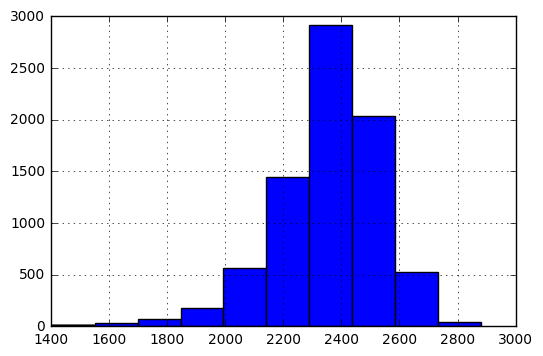

In [37]:
df['rating'].hist()

## Elo Rating vs. Games Played

The database records the number of games played.  Naturally, more games are more opportunities for one's rating to rise.  Surely some players of greater skill or point aquiring strategies will ascend faster.  But by how much?  The plot below seems to indicate it's a slow climb.

In [38]:
df['games'] = df['games'].apply(lambda x: int(x.replace(',', '')))

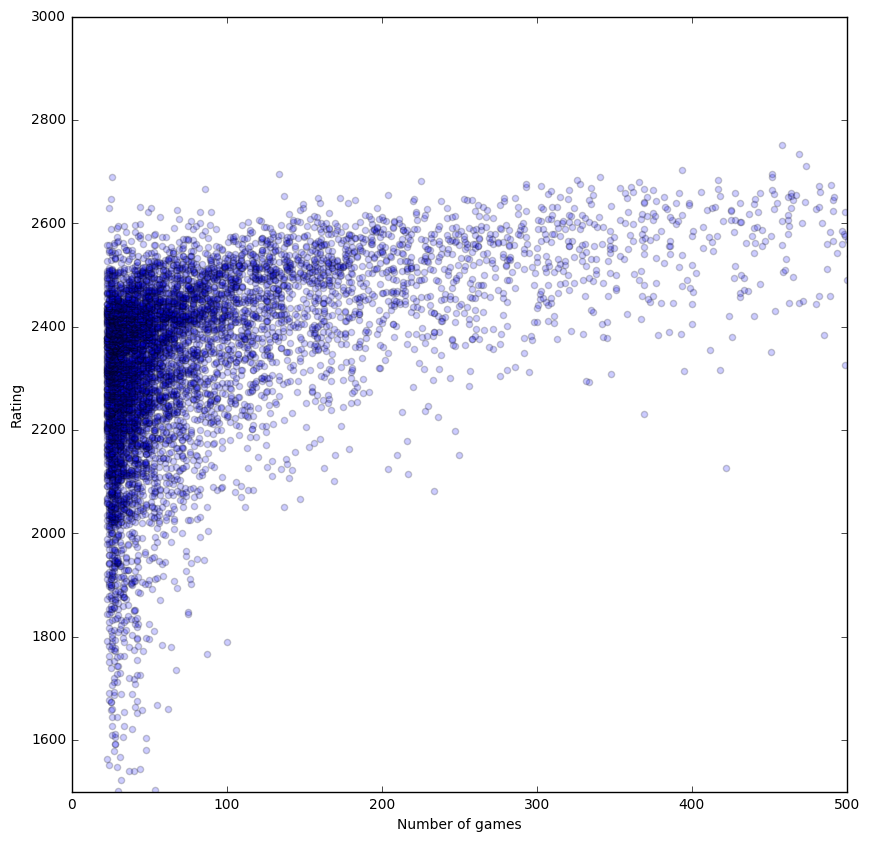

In [40]:
plt.figure(figsize=(10,10))
plt.scatter(df['games'], df['rating'], alpha=0.2)
plt.xlabel('Number of games')
plt.ylabel('Rating')
plt.ylim([1500, 3000])
plt.xlim([0, 500])
plt.show()